### Axon segmentation using channel colors
- IMAGE LOADING SECTION : Change the tif image reading path in both locations
- USER INPUT - CROPPING REGION: Change the X_START_POSI, Y_START_POSI (0.35 means 35%) and crop_size (image size you want)
- COLOR ADJUSTING SECTION : This will enable user to tweak the min and max color intensities
- CROPPING 4 IMAGES SOURROUNDING TO CENTER IMAGE: This will give you x,y cordinates with start and end for each image
- PLOTTING 4 CROPPED IMAGES WITH THE ADJUSTED COLOR SETTINGS: Plots 4 images with the adjusted color settings
- PLOTTING COMPLETE IMAGE : Plotting complete image on latest color settings
- ALL POLYGONS AS GEOJSON : All polygons will be saved as GeoJson file in this section
- FILTERING POLYGONS WITH MINIMUM AREA TO A GEOJSON : This filters the above all polygons based on given min area

<pre> ``` project-folder/ 
├── Input/ 
    ├── morphology_focus_0000.ome.tif 
    │── morphology_focus_0001.ome.tif 
├── Output/ 
    ├── mask_polygons_all_Ipywsettings.geojson 
    │── mask_polygons_all_Ipywsettings_areabelow250.gejson 
├── Split-Image-SettingsApp-RunPipeline-v2.ipynb

In [12]:
import tifffile as tiff
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
############## IMAGE LOADING SECTION ###################
# Load the multi-channel TIFF image
img1 = tiff.imread("./Input/morphology_focus_0000.ome.tif")  #change this path
# Shape: [channels, height, width] or [height, width, channels]
print(img1.shape)

import tifffile
# Open the file
with tifffile.TiffFile("./Input/morphology_focus_0000.ome.tif") as tif:
    ome_metadata = tif.ome_metadata  # Raw OME-XML string

    # Optionally print the metadata
    print(ome_metadata)

OME series: cannot read multi-file pyramids


(4, 13748, 19987)
<OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd" UUID="urn:uuid:353814e0-d397-11ef-b8ba-7cc255e179e3">
  <Plate ID="Plate:0" WellOriginX="0.0" WellOriginXUnit="µm" WellOriginY="0.0" WellOriginYUnit="µm"/>
  <Instrument ID="Instrument:0">
    <Microscope Manufacturer="10x Genomics" Model="Xenium"/>
  </Instrument>
  <Image ID="Image:0">
    <InstrumentRef ID="Instrument:0"/>
    <Pixels ID="Pixels:0" DimensionOrder="XYZCT" Type="uint16" SizeX="19987" SizeY="13748" SizeZ="1" SizeC="4" SizeT="1" PhysicalSizeX="0.2125" PhysicalSizeXUnit="µm" PhysicalSizeY="0.2125" PhysicalSizeYUnit="µm">
      <Channel ID="Channel:0" Name="DAPI" SamplesPerPixel="1">
        <AnnotationRef ID="Annotation:0"/>
      </Channel>
      <Channel ID="Channel:1" Name="ATP1A1/CD45/E-Cadherin" SamplesPerP

In [3]:
##################### CHANNEL SELECTION #####################
mask1 = img1[0]  # DAPI
mask2 = img1[2]  # 18S

print("DAPI:",mask1.shape[0])
print("18S:",mask2.shape[0])
print("Shape: ",mask1.shape)

DAPI: 13748
18S: 13748
Shape:  (13748, 19987)


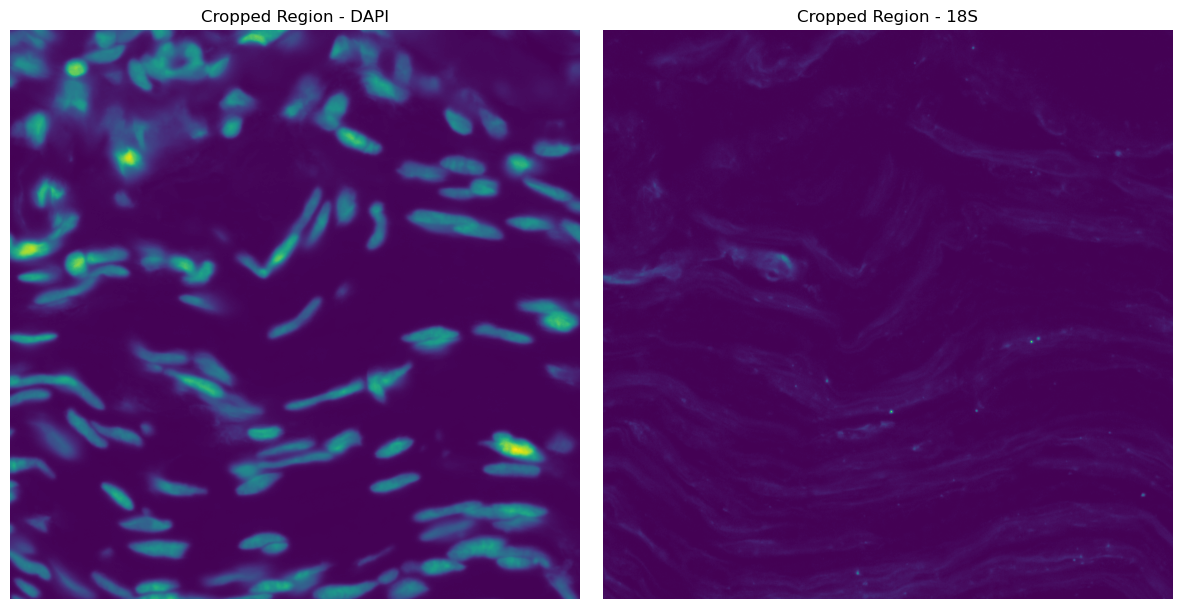

In [4]:
####### USER INPUT - CROPPING REGION ##########
X_START_POSI = 0.35
Y_START_POSI = 0.65
crop_size = 1024 # pixels

# --- Define crop region ---
x_start = int(mask1.shape[1]*X_START_POSI) # x axis starting point, 35% from left side of the image
y_start = int(mask1.shape[0]*Y_START_POSI) # y axis starting point, 65% from top of the image

# --- Crop DAPI ---
y_end = min(y_start + crop_size, mask1.shape[0])
x_end = min(x_start + crop_size, mask1.shape[1])
cropped_img1 = mask1[y_start:y_end, x_start:x_end]

# --- Crop 18S ---
y_end = min(y_start + crop_size, mask2.shape[0])
x_end = min(x_start + crop_size, mask2.shape[1])
cropped_img2 = mask2[y_start:y_end, x_start:x_end]

# --- Combined Plot ---
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(cropped_img1)
axs[0].set_title("Cropped Region - DAPI")
axs[0].axis('off')

axs[1].imshow(cropped_img2)
axs[1].set_title("Cropped Region - 18S")
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [5]:
################################### COLOR ADJUSTING SECTION ######################################
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Shared dictionary to hold the latest values
latest_values = {
    'dapi_min': None,
    'dapi_max': None,
    's18_min': None,
    's18_max': None,
    'zoom': 1
}

mask1 = cropped_img1  # DAPI (blue)
mask2 = cropped_img2  # 18S  (green)

def update_display(DAPI_min, DAPI_max, _18S_min, _18S_max, zoom):
    # Store updated values
    latest_values.update({
        'dapi_min': DAPI_min,
        'dapi_max': DAPI_max,
        's18_min': _18S_min,
        's18_max': _18S_max,
        'zoom': zoom
    })
    
    # Apply thresholding
    mask1_thresh = np.clip(mask1, DAPI_min, DAPI_max)
    mask2_thresh = np.clip(mask2, _18S_min, _18S_max)
    
    # Normalize to 0-255
    mask1_norm = cv2.normalize(mask1_thresh, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    mask2_norm = cv2.normalize(mask2_thresh, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    _, bin_mask1 = cv2.threshold(mask1_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, bin_mask2 = cv2.threshold(mask2_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    mask1_bool = bin_mask1 > 0
    mask2_bool = bin_mask2 > 0
    unique_mask = np.logical_and(mask2_bool, ~mask1_bool)

    # RGB merge
    merged_rgb = np.stack([
        np.zeros_like(mask1_norm),
        mask2_norm,
        mask1_norm
    ], axis=-1)

    # --- Zoom calculation ---
    h, w = mask1.shape
    zh, zw = h // zoom, w // zoom
    y0, y1 = (h - zh) // 2, (h + zh) // 2
    x0, x1 = (w - zw) // 2, (w + zw) // 2

    def set_zoom(ax):
        ax.set_xlim(x0, x1)
        ax.set_ylim(y1, y0)  # y is inverted in imshow

    # Plot
    fig, axes = plt.subplots(1, 5, figsize=(24, 6))

    axes[0].imshow(merged_rgb)
    axes[0].set_title("Original Channels Merged")
    set_zoom(axes[0])
    axes[0].axis('off')

    axes[1].imshow(mask1_bool, cmap='Blues')
    axes[1].set_title("DAPI Mask")
    set_zoom(axes[1])
    axes[1].axis('off')

    axes[2].imshow(mask2_bool, cmap='Greens')
    axes[2].set_title("18S Mask")
    set_zoom(axes[2])
    axes[2].axis('off')

    axes[3].imshow(mask1_bool, cmap='Blues', alpha=0.7)
    axes[3].imshow(mask2_bool, cmap='Greens', alpha=0.5)
    axes[3].imshow(unique_mask, cmap='Purples', alpha=0.4)
    axes[3].set_title("Overlay (DAPI + 18S + Unique)")
    set_zoom(axes[3])
    axes[3].axis('off')

    axes[4].imshow(unique_mask, cmap='Purples')
    axes[4].set_title("Axons Mask (18S - DAPI)")
    set_zoom(axes[4])
    axes[4].axis('off')

    plt.tight_layout()
    plt.show()

# Interactive sliders
interact(
    update_display,
    DAPI_min=IntSlider(min=int(mask1.min()), max=int(mask1.max()), step=1, value=int(mask1.min())),
    DAPI_max=IntSlider(min=int(mask1.min()), max=int(mask1.max()), step=1, value=int(mask1.max())),
    _18S_min=IntSlider(min=int(mask2.min()), max=int(mask2.max()), step=1, value=int(mask2.min())),
    _18S_max=IntSlider(min=int(mask2.min()), max=int(mask2.max()), step=1, value=int(mask2.max())),
    zoom=IntSlider(min=1, max=8, step=1, value=1, description="Zoom (x)")
)


interactive(children=(IntSlider(value=12, description='DAPI_min', max=7206, min=12), IntSlider(value=7206, des…

<function __main__.update_display(DAPI_min, DAPI_max, _18S_min, _18S_max, zoom)>

In [8]:
###################### CROPPING 4 IMAGES SOURROUNDING TO CENTER IMAGE #######################
mask1 = img1[0]  # DAPI
mask2 = img1[2]  # 18S

x_start = int(mask1.shape[1]*X_START_POSI)
y_start = int(mask1.shape[0]*Y_START_POSI)

####### TOP IMAGE ########
x_start = int(mask1.shape[1]*X_START_POSI)
x_end = min(x_start + crop_size, mask1.shape[1])
y_start = int(mask1.shape[0]*Y_START_POSI)-crop_size
y_end = int(mask1.shape[0]*Y_START_POSI)

y_start = max(y_start,0)

T_cropped_img1 = mask1[y_start:y_end, x_start:x_end]
# --- Crop 18S ---
T_cropped_img2 = mask2[y_start:y_end, x_start:x_end]
print("Top Image:",x_start,x_end,y_start,y_end)
####### RIGHT IMAGE ########
x_start = int(mask1.shape[1]*X_START_POSI)
y_start = int(mask1.shape[0]*Y_START_POSI)

x_start = int(mask1.shape[1]*X_START_POSI)+crop_size
y_start = int(mask1.shape[0]*Y_START_POSI)
y_end = int(mask1.shape[0]*Y_START_POSI)+crop_size

x_end = min(x_start + crop_size, mask1.shape[1])
R_cropped_img1 = mask1[y_start:y_end, x_start:x_end]
# --- Crop 18S ---
R_cropped_img2 = mask2[y_start:y_end, x_start:x_end]
print("RIGHT Image:",x_start,x_end,y_start,y_end)
####### BOTTOM IMAGE ########
x_start = int(mask1.shape[1]*X_START_POSI)
y_start = int(mask1.shape[0]*Y_START_POSI)+crop_size

x_end = min(x_start + crop_size, mask1.shape[1])
y_end = min(y_start+crop_size,mask1.shape[0])

B_cropped_img1 = mask1[y_start:y_end, x_start:x_end]
# --- Crop 18S ---
B_cropped_img2 = mask2[y_start:y_end, x_start:x_end]
print("BOTTOM Image:",x_start,x_end,y_start,y_end)
####### LEFT IMAGE ########
x_start = int(mask1.shape[1]*X_START_POSI)-crop_size
x_end = int(mask1.shape[1]*X_START_POSI)

y_start = int(mask1.shape[0]*Y_START_POSI)
y_end = int(mask1.shape[0]*Y_START_POSI)+1024

x_start = max(x_start,0)
L_cropped_img1 = mask1[y_start:y_end, x_start:x_end]
# --- Crop 18S ---
L_cropped_img2 = mask2[y_start:y_end, x_start:x_end]
print("LEFT Image:",x_start,x_end,y_start,y_end)


Top Image: 6995 8019 7912 8936
RIGHT Image: 8019 9043 8936 9960
BOTTOM Image: 6995 8019 9960 10984
LEFT Image: 5971 6995 8936 9960


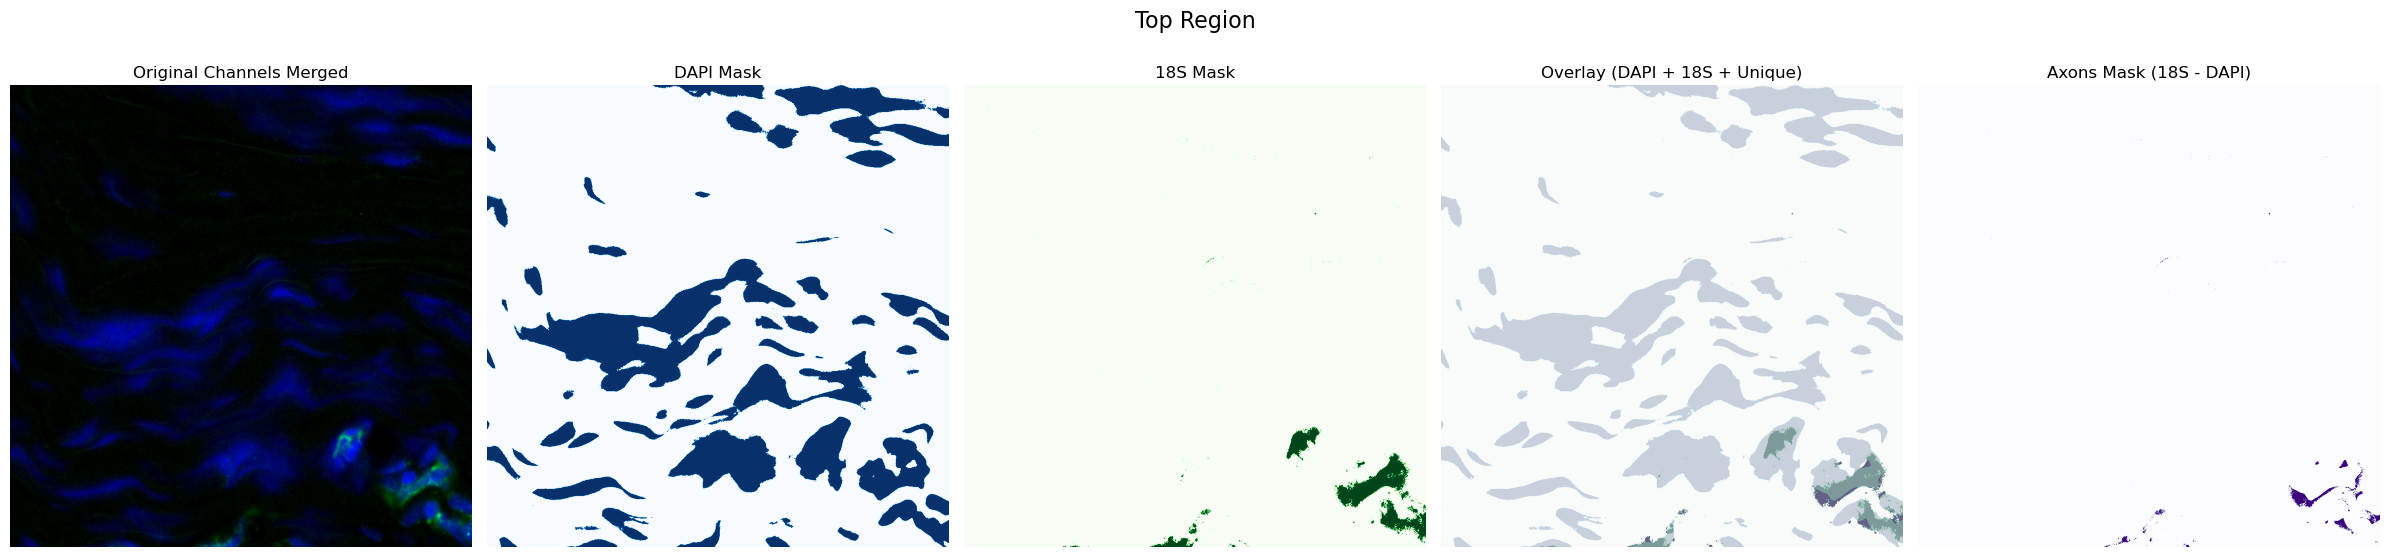

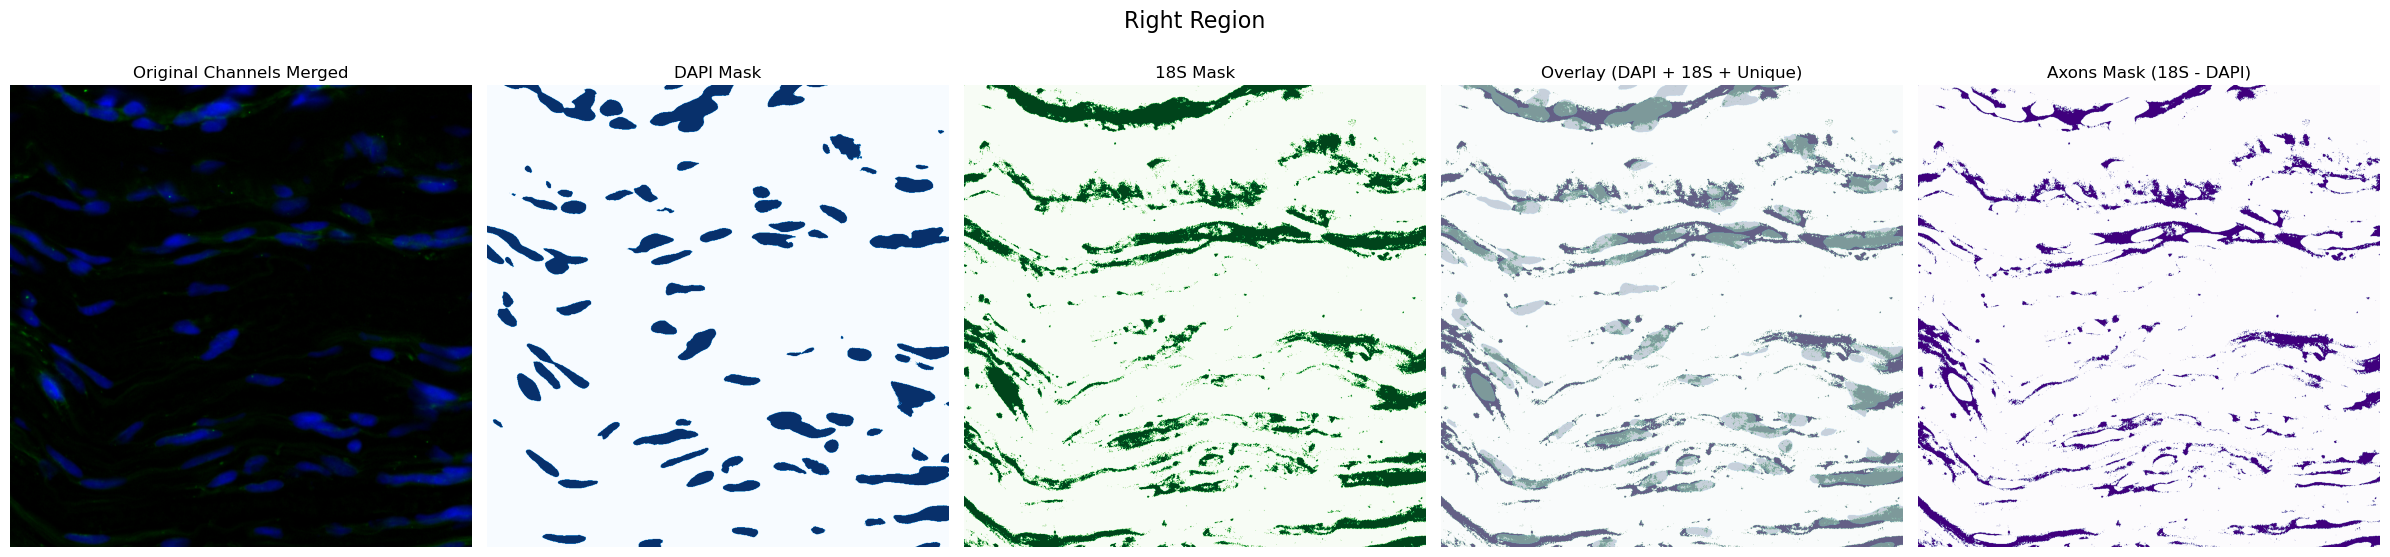

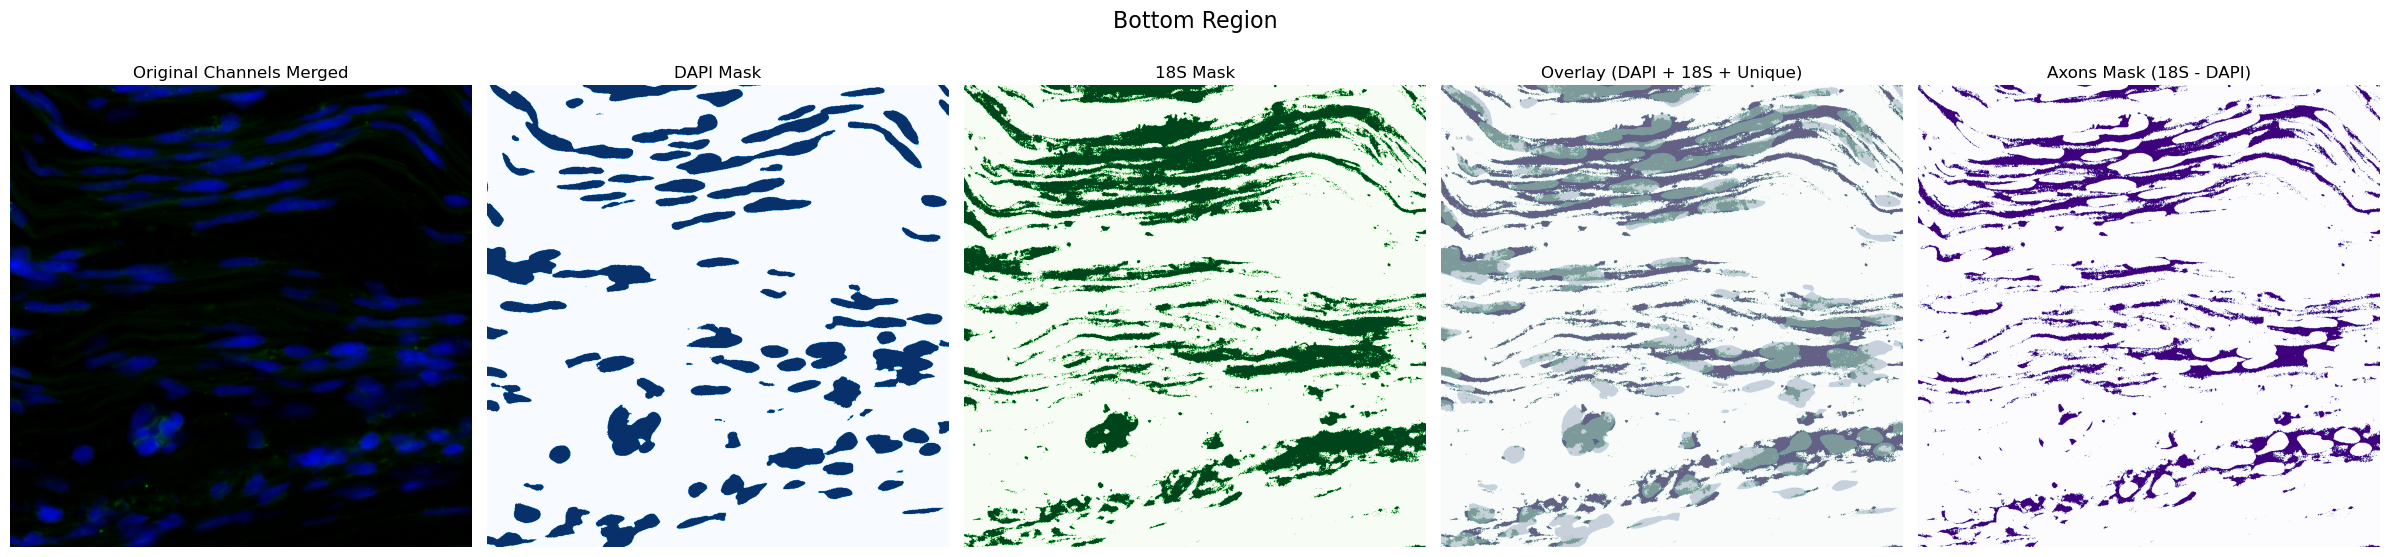

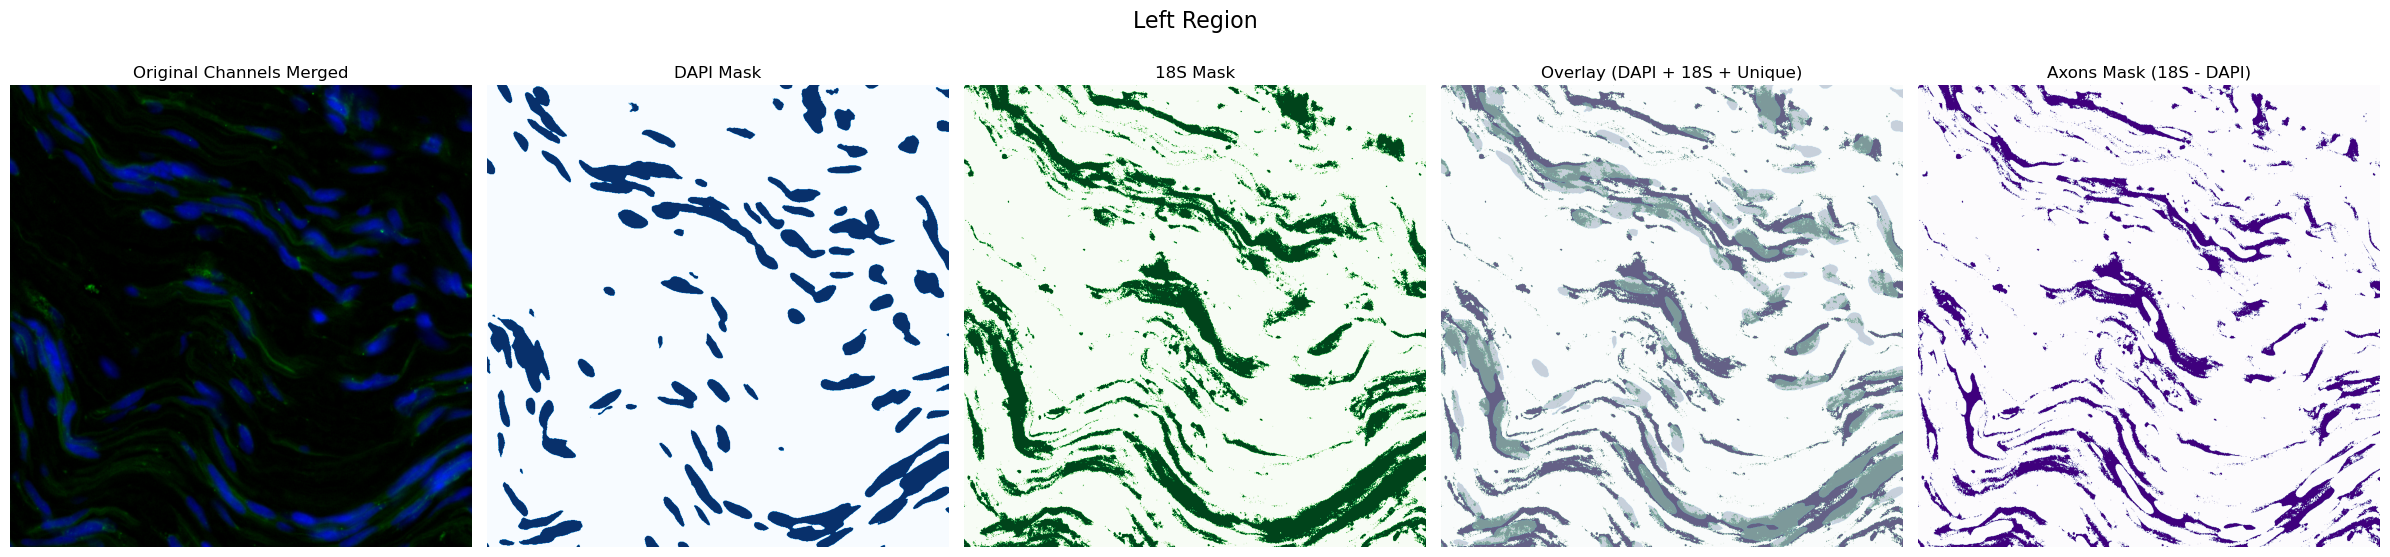

In [14]:
################ PLOTTING 4 CROPPED IMAGES WITH THE ADJUSTED COLOR SETTINGS ##########################
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_cropped_regions(crops_dict, latest_values, save_dir="Plots"):
    dapi_min = latest_values['dapi_min']
    dapi_max = latest_values['dapi_max']
    s18_min = latest_values['s18_min']
    s18_max = latest_values['s18_max']
    
    # Create the output directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    for label, (crop1, crop2) in crops_dict.items():
        # Threshold and normalize
        crop1_thresh = np.clip(crop1, dapi_min, dapi_max)
        crop2_thresh = np.clip(crop2, s18_min, s18_max)

        crop1_norm = cv2.normalize(crop1_thresh, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        crop2_norm = cv2.normalize(crop2_thresh, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        _, bin1 = cv2.threshold(crop1_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        _, bin2 = cv2.threshold(crop2_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        mask1_bool = bin1 > 0
        mask2_bool = bin2 > 0
        unique_mask = np.logical_and(mask2_bool, ~mask1_bool)

        # RGB merge
        merged_rgb = np.stack([
            np.zeros_like(crop1_norm),
            crop2_norm,
            crop1_norm
        ], axis=-1)

        # Plot
        fig, axes = plt.subplots(1, 5, figsize=(24, 6))
        fig.suptitle(f"{label} Region", fontsize=16)

        axes[0].imshow(merged_rgb)
        axes[0].set_title("Original Channels Merged")
        axes[0].axis('off')

        axes[1].imshow(mask1_bool, cmap='Blues')
        axes[1].set_title("DAPI Mask")
        axes[1].axis('off')

        axes[2].imshow(mask2_bool, cmap='Greens')
        axes[2].set_title("18S Mask")
        axes[2].axis('off')

        axes[3].imshow(mask1_bool, cmap='Blues', alpha=0.7)
        axes[3].imshow(mask2_bool, cmap='Greens', alpha=0.5)
        axes[3].imshow(unique_mask, cmap='Purples', alpha=0.4)
        axes[3].set_title("Overlay (DAPI + 18S + Unique)")
        axes[3].axis('off')

        axes[4].imshow(unique_mask, cmap='Purples')
        axes[4].set_title("Axons Mask (18S - DAPI)")
        axes[4].axis('off')

        plt.tight_layout()
        # Save the figure using label in filename
        save_path = os.path.join(save_dir, f"{label}_region_plot.png")
        plt.savefig(save_path, dpi=300)
        plt.show()

# --- Prepare pre-cropped images ---
crops_dict = {
    "Top":    (T_cropped_img1, T_cropped_img2),
    "Right":  (R_cropped_img1, R_cropped_img2),
    "Bottom": (B_cropped_img1, B_cropped_img2),
    "Left":   (L_cropped_img1, L_cropped_img2)
}

# --- Plot them ---
plot_cropped_regions(crops_dict, latest_values)


mask1 min: 0 max: 10041
mask2 min: 0 max: 6187
DAPI min: 557 DAPI max: 6881
18S min: 0 18S max: 1569


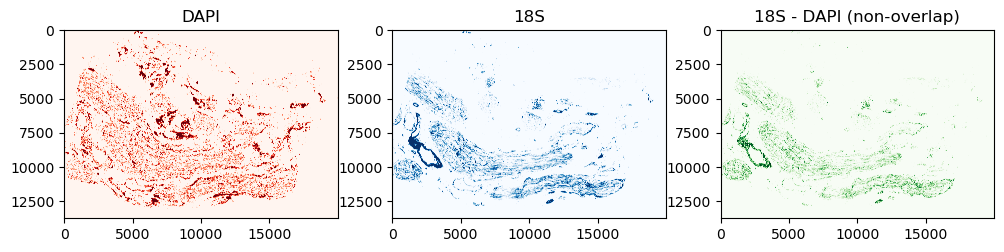

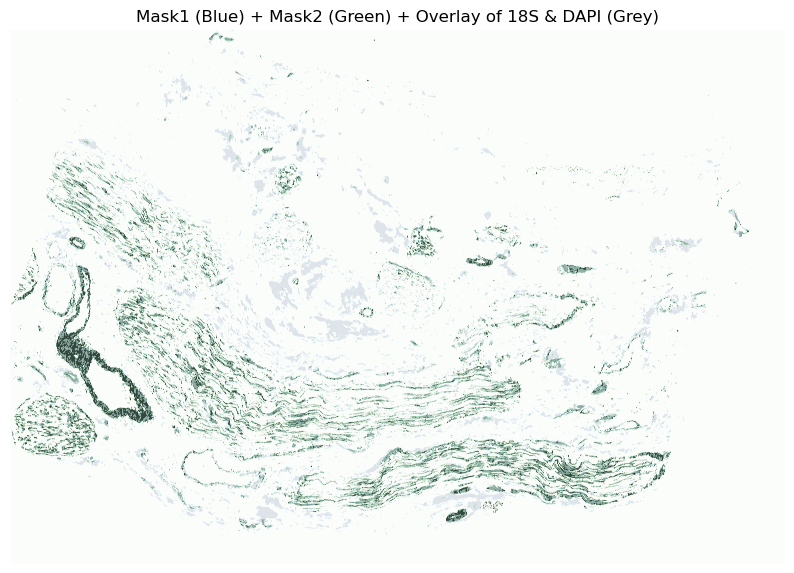

In [15]:
################ PLOTTING COMPLETE IMAGE ####################
######## USER INPUT ##########
mask1_FI = img1[0]  # DAPI
mask2_FI = img1[2]  # 18S

print("mask1 min:", mask1_FI.min(), "max:", mask1_FI.max())
print("mask2 min:", mask2_FI.min(), "max:", mask2_FI.max())
print("DAPI min:", latest_values['dapi_min'], "DAPI max:", latest_values['dapi_max'])
print("18S min:", latest_values['s18_min'], "18S max:", latest_values['s18_max'])

# Apply intensity thresholds
mask1_thresh_FI = np.clip(mask1_FI, latest_values['dapi_min'], latest_values['dapi_max'])
mask2_thresh_FI = np.clip(mask2_FI, latest_values['s18_min'], latest_values['s18_max'])

# Normalize
mask1_norm_FI = cv2.normalize(mask1_thresh_FI, None, 0, 255, cv2.NORM_MINMAX)
mask2_norm_FI = cv2.normalize(mask2_thresh_FI, None, 0, 255, cv2.NORM_MINMAX)

# Optional: Binarize masks (if not already)
_, bin_mask1_FI = cv2.threshold(mask1_norm_FI, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, bin_mask2_FI = cv2.threshold(mask2_norm_FI, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Convert to boolean masks
mask1_bool_FI = bin_mask1_FI > 0
mask2_bool_FI = bin_mask2_FI > 0

unique_mask_FI = np.logical_and(mask2_bool_FI, ~mask1_bool_FI)

# Display
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(mask1_bool_FI, cmap='Reds')
plt.title("DAPI")

plt.subplot(1, 3, 2)
plt.imshow(mask2_bool_FI, cmap='Blues')
plt.title("18S")

plt.subplot(1, 3, 3)
plt.imshow(unique_mask_FI, cmap='Greens')
plt.title("18S - DAPI (non-overlap)")
plt.show()

# Step 5: Plot with overlay
fig, ax = plt.subplots(figsize=(10, 10))  # You can change size for higher res
ax.imshow(mask1_bool_FI, cmap='Blues', alpha=0.6)
ax.imshow(mask2_bool_FI, cmap='Greens', alpha=0.6)
ax.imshow(unique_mask_FI, cmap='Greys', alpha=0.5)  # Highlight unique mask2 region

ax.set_title("Mask1 (Blue) + Mask2 (Green) + Overlay of 18S & DAPI (Grey)")
ax.axis('off')

plt.show()

In [16]:
#np.unique(bin_mask1_FI)

array([  0, 255], dtype=uint16)

In [17]:
########### ALL POLYGONS AS GEOJSON #################
import numpy as np
from skimage import measure
from shapely.geometry import Polygon, mapping
import geojson
import json

# Suppose unique_mask is a 2D numpy array of dtype bool
# Example: unique_mask = np.logical_and(mask1_bool, ~mask2_bool)

# Step 1: Find contours at the 0.5 level
contours = measure.find_contours(unique_mask_FI.astype(float), level=0.5)

# Step 2: Convert contours to polygons
polygons = []
for contour in contours:
    # flip (row, col) to (x, y)
    coords = [(float(x), float(y)) for y, x in contour]
    if len(coords) >= 3:  # valid polygon
        poly = Polygon(coords)
        if poly.is_valid:
            polygons.append(mapping(poly))

# Step 3: Create GeoJSON FeatureCollection
features = [geojson.Feature(geometry=poly, properties={}) for poly in polygons]
feature_collection = geojson.FeatureCollection(features)

# Step 4: Save to GeoJSON file
with open("./Output/mask_polygons_all_Ipywsettings.geojson", "w") as f:
    geojson.dump(feature_collection, f)


In [18]:
########### FILTERING POLYGONS WITH MINIMUM AREA TO A GEOJSON #################
######## MAKE SURE BELOW GEOJSON FILE NAME SAME AS ABOVE SAVED FILE ###########
import json
from shapely.geometry import shape, mapping

####### USER INPUT ##########
# Set your pixel area threshold
MIN_AREA = 250  # Change as per your requirement

# READING THE SAVED GeoJSON
with open("./Output/mask_polygons_all_Ipywsettings.geojson", "r") as f:
    geojson_data = json.load(f)

# Filter features
filtered_features = []
for feature in geojson_data["features"]:
    geom = shape(feature["geometry"])
    area = geom.area  # Area in pixel²
    if area >= MIN_AREA:
        filtered_features.append(feature)

# Create new GeoJSON
filtered_geojson = {
    "type": "FeatureCollection",
    "features": filtered_features
}

# Save to new file
with open("./Output/mask_polygons_Ipywsettings_AreaAbove250.geojson", "w") as f:
    json.dump(filtered_geojson, f, indent=2)

print(f"Filtered GeoJSON saved with {len(filtered_features)} features.")


Filtered GeoJSON saved with 4249 features.


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2

# def plot_surrounding_crops(mask1, mask2, latest_values, x_start, y_start, crop_size):
#     dapi_min = latest_values['dapi_min']
#     dapi_max = latest_values['dapi_max']
#     s18_min = latest_values['s18_min']
#     s18_max = latest_values['s18_max']

#     # Define the 4 surrounding square positions
#     directions = {
#         "Left":   (y_start, x_start - crop_size),
#         "Right":  (y_start, x_start + crop_size),
#         "Above":  (y_start - crop_size, x_start),
#         "Below":  (y_start + crop_size, x_start)
#     }

#     for label, (ys, xs) in directions.items():
#         # Compute bounds safely
#         ye = min(ys + crop_size, mask1.shape[0])
#         xe = min(xs + crop_size, mask1.shape[1])
#         ys = max(0, ys)
#         xs = max(0, xs)

#         # Crop the region
#         crop1 = mask1[ys:ye, xs:xe]
#         crop2 = mask2[ys:ye, xs:xe]

#         # Threshold and normalize
#         crop1_thresh = np.clip(crop1, dapi_min, dapi_max)
#         crop2_thresh = np.clip(crop2, s18_min, s18_max)

#         crop1_norm = cv2.normalize(crop1_thresh, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
#         crop2_norm = cv2.normalize(crop2_thresh, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

#         _, bin1 = cv2.threshold(crop1_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#         _, bin2 = cv2.threshold(crop2_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#         mask1_bool = bin1 > 0
#         mask2_bool = bin2 > 0
#         unique_mask = np.logical_and(mask2_bool, ~mask1_bool)

#         # RGB merge
#         merged_rgb = np.stack([
#             np.zeros_like(crop1_norm),
#             crop2_norm,
#             crop1_norm
#         ], axis=-1)

#         # Plot
#         fig, axes = plt.subplots(1, 5, figsize=(24, 6))
#         fig.suptitle(f"{label} Region", fontsize=16)

#         axes[0].imshow(merged_rgb)
#         axes[0].set_title("Original Channels Merged")
#         axes[0].axis('off')

#         axes[1].imshow(mask1_bool, cmap='Blues')
#         axes[1].set_title("DAPI Mask")
#         axes[1].axis('off')

#         axes[2].imshow(mask2_bool, cmap='Greens')
#         axes[2].set_title("18S Mask")
#         axes[2].axis('off')

#         axes[3].imshow(mask1_bool, cmap='Blues', alpha=0.7)
#         axes[3].imshow(mask2_bool, cmap='Greens', alpha=0.5)
#         axes[3].imshow(unique_mask, cmap='Purples', alpha=0.4)
#         axes[3].set_title("Overlay (DAPI + 18S + Unique)")
#         axes[3].axis('off')

#         axes[4].imshow(unique_mask, cmap='Purples')
#         axes[4].set_title("Axons Mask (18S - DAPI)")
#         axes[4].axis('off')

#         plt.tight_layout()
#         plt.show()

# # --- Input parameters based on your crop ---
# x_start = int(mask1.shape[1] * 0.35)
# y_start = int(mask1.shape[0] * 0.65)
# crop_size = 1024

# # Run for the 4 adjacent squares
# plot_surrounding_crops(mask1, mask2, latest_values, x_start, y_start, crop_size)


In [ ]:
# def plot_with_zoom(zoom=1):
#     ######## USER INPUT ##########
#     mask1_FI = img1[0]  # DAPI
#     mask2_FI = img1[2]  # 18S

#     print("mask1 min:", mask1_FI.min(), "max:", mask1_FI.max())
#     print("mask2 min:", mask2_FI.min(), "max:", mask2_FI.max())
#     print("DAPI min:", latest_values['dapi_min'], "DAPI max:", latest_values['dapi_max'])
#     print("18S min:", latest_values['s18_min'], "18S max:", latest_values['s18_max'])

#     # Apply thresholds
#     mask1_thresh_FI = np.clip(mask1_FI, latest_values['dapi_min'], latest_values['dapi_max'])
#     mask2_thresh_FI = np.clip(mask2_FI, latest_values['s18_min'], latest_values['s18_max'])

#     # Normalize
#     mask1_norm_FI = cv2.normalize(mask1_thresh_FI, None, 0, 255, cv2.NORM_MINMAX)
#     mask2_norm_FI = cv2.normalize(mask2_thresh_FI, None, 0, 255, cv2.NORM_MINMAX)

#     # Binarize
#     _, bin_mask1_FI = cv2.threshold(mask1_norm_FI, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#     _, bin_mask2_FI = cv2.threshold(mask2_norm_FI, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#     mask1_bool_FI = bin_mask1_FI > 0
#     mask2_bool_FI = bin_mask2_FI > 0
#     unique_mask_FI = np.logical_and(mask2_bool_FI, ~mask1_bool_FI)

#     # ---- ZOOM logic ----
#     h, w = mask1_bool_FI.shape
#     zh, zw = h // zoom, w // zoom
#     y0, y1 = (h - zh) // 2, (h + zh) // 2
#     x0, x1 = (w - zw) // 2, (w + zw) // 2

#     mask1_crop = mask1_bool_FI[y0:y1, x0:x1]
#     mask2_crop = mask2_bool_FI[y0:y1, x0:x1]
#     unique_crop = unique_mask_FI[y0:y1, x0:x1]

#     # Display masks
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 3, 1)
#     plt.imshow(mask1_crop, cmap='Reds')
#     plt.title("DAPI")
#     plt.axis('off')

#     plt.subplot(1, 3, 2)
#     plt.imshow(mask2_crop, cmap='Blues')
#     plt.title("18S")
#     plt.axis('off')

#     plt.subplot(1, 3, 3)
#     plt.imshow(unique_crop, cmap='Greens')
#     plt.title("18S - DAPI (non-overlap)")
#     plt.axis('off')

#     plt.tight_layout()
#     plt.show()

#     # Overlay plot
#     fig, ax = plt.subplots(figsize=(10, 10))
#     ax.imshow(mask1_crop, cmap='Blues', alpha=0.6)
#     ax.imshow(mask2_crop, cmap='Greens', alpha=0.6)
#     ax.imshow(unique_crop, cmap='Greys', alpha=0.5)

#     ax.set_title("DAPI (Blue) + 18S (Green) + Overlay (Grey)")
#     ax.axis('off')
#     plt.show()

# # Add zoom slider (1 = full, 2 = 2× zoom, etc.)
# interact(plot_with_zoom, zoom=IntSlider(min=1, max=8, step=1, value=1))
